This notebook provides the solution for the Assignment 2 !



In [191]:
'''
This block only installs the necessary dependencies onto the system. If the libs are already installed, then no need to execute this command.

Known issues 
- The pyfolio lib only works with pandas version < 2.0.0, therefore the highest version below 2.0.0 ( i.e. 1.5.3 ) is used

'''
%pip install pandas==1.5.3
%pip install yfinance==0.2.37
%pip install pyfolio=0.9.2
%pip install empyrical=0.5.5
%pip install pydantic==2.6.3
%pip install matplotlib==3.8.3
%pip install ta==0.11.0
%pip install backtesting

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Invalid requirement: 'pyfolio=0.9.2'
Hint: = is not a valid operator. Did you mean == ?
Note: you may need to restart the kernel to use updated packages.
ERROR: Invalid requirement: 'empyrical=0.5.5'
Hint: = is not a valid operator. Did you mean == ?
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.6 MB/s eta 0:00:00m eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 10.3 MB/s eta 0:00:

In [192]:
# import the libs
import pandas as pd
import pandas as pd
import yfinance as yf
import pyfolio as pf
import datetime as dt
import empyrical as em
import ta
import numpy as np
from pydantic import BaseModel
import warnings
from scipy.stats import norm

# Ignore printing all warnings
warnings.filterwarnings('ignore')

In [193]:
class Settings( BaseModel ):
    period   : str = "1y"
    interval : str = "1d"
    tmp_folder: str = 'tmp'
    yahoo_ticker_ext: str = ".NS"
    risk_free_rate: float = 0.067188
    days_in_year: int = 252

setting = Settings( )

# dataframes to hold the metrics related data
descriptive_stats = pd.DataFrame( ) 
custom_metrics = pd.DataFrame( )
pyfolio_metrics = pd.DataFrame( )

def get_performance_metrics( return_data ):

    # calcuate the annual ration
    annual_return       = np.mean( return_data ) * setting.days_in_year
    
    # calculate annual volatility ratio
    annual_volatility   = np.std(return_data) * np.sqrt( setting.days_in_year )
    
    # calculate sharpe ratio
    sharpe_ratio        = (annual_return - setting.risk_free_rate) / annual_volatility

    # calculate rolling max window
    rolling_max = return_data.cummax()

    # daily drawdown
    daily_drawdown = return_data / rolling_max - 1.0
    
    max_drawdown = daily_drawdown.cummin().min()

    calmar_ratio = (annual_return - setting.risk_free_rate ) / abs(max_drawdown)

    daily_var = norm.ppf(1-0.05, np.mean(return_data), np.std(return_data))

    negative_std = np.std( return_data [return_data < 0])
    sortino_ratio = (annual_return -setting.risk_free_rate)/(negative_std * np.sqrt(252))

    positive_returns_sum = np.sum( return_data[return_data > 0])
    negative_returns_sum = np.sum( return_data[return_data < 0])
    omega_ratio = positive_returns_sum / abs(negative_returns_sum)

    tail_ratio = abs(np.percentile(return_data.dropna(), 95)) / abs(np.percentile( return_data.dropna(), 5))

    metrics = {
        'annual_return': annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio' : sharpe_ratio,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio,
        'daily_value_at_risk': daily_var,
        'sortino_ratio': sortino_ratio,
        'omega_ratio': omega_ratio,
        'tail_ratio': tail_ratio
    }

    return metrics

# download the data from yfinance
stock_symbol = "ICICIBANK.NS" 
drop_column_list =  ['Open', 'Volume', 'Stock Splits', 'Dividends']

ticker = yf.Ticker( stock_symbol )
ticker_df = ticker.history( period=setting.period, interval=setting.interval )
ticker_df.dropna(inplace = True)
ticker_df['daily_returns'] = np.log(ticker_df['Close']/ticker_df['Close'].shift(1))

ticker_df.drop( drop_column_list ,axis=1, inplace=True, errors='ignore')

ticker_df.head( )

,High,Low,Close,daily_returns
Date,,,,
2023-03-08 00:00:00+05:30,866.517436,854.466605,864.980042,NaN
2023-03-09 00:00:00+05:30,862.698816,847.176622,848.961914,-0.018692
2023-03-10 00:00:00+05:30,838.448477,829.422795,835.770569,-0.015660
2023-03-13 00:00:00+05:30,848.317252,817.223220,821.636902,-0.017056
2023-03-14 00:00:00+05:30,827.637486,811.569733,823.570923,0.002351


Start date,2023-03-08
End date,2024-03-07
Total months,11
,Backtest
Annual return,7.2%
Cumulative returns,7.0%
Annual volatility,12.2%
Sharpe ratio,0.68
Calmar ratio,0.55
Stability,0.23
Max drawdown,-12.9%


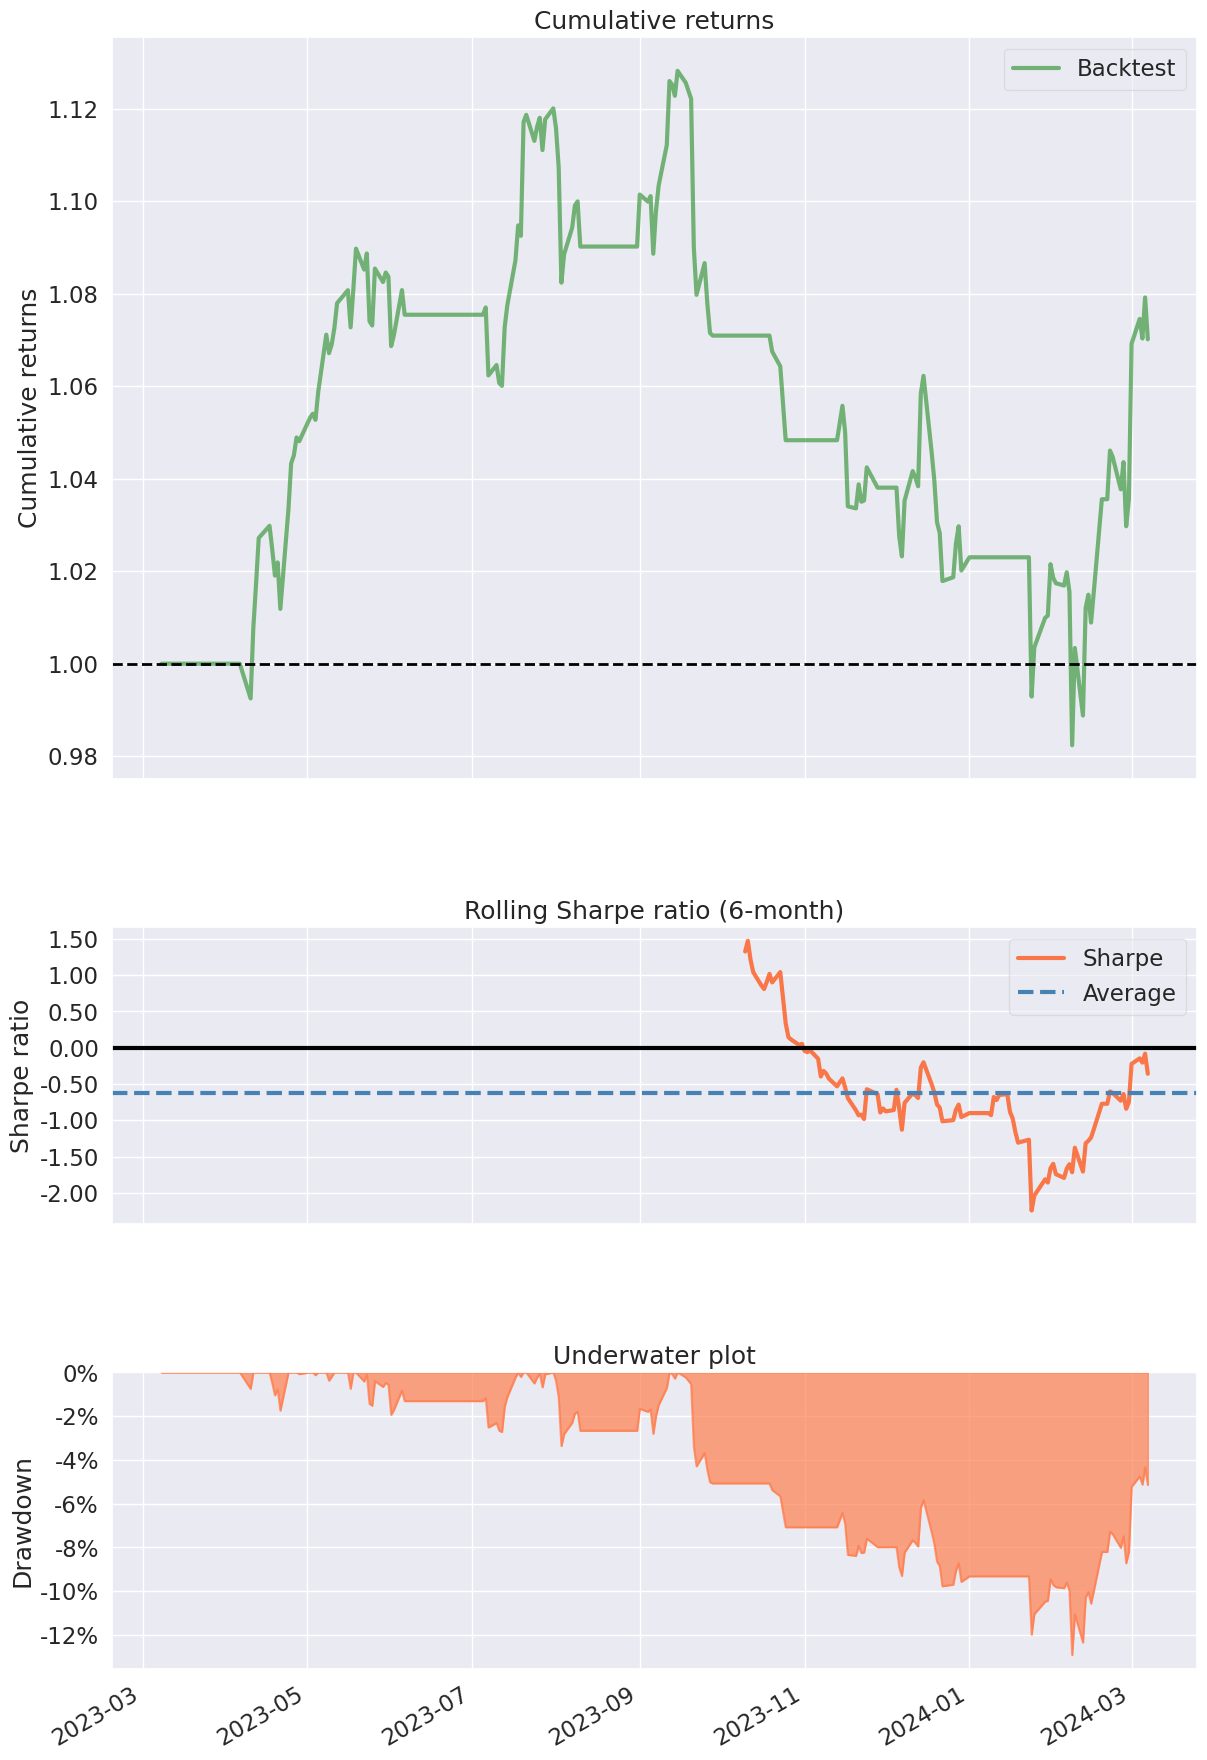

In [194]:
# Setting up the calculations for Simple Moving Average - Cross Over

df_sma = ticker_df.copy( deep=True )
long_window  = 20
short_window = 10

df_sma[ 'short'] = ta.trend.SMAIndicator( df_sma['Close'], window=short_window).sma_indicator()
df_sma[ 'long' ] = ta.trend.SMAIndicator( df_sma['Close'], window=long_window ).sma_indicator()

# SMA Cross over Strategy 

# Position Strategy
# BUY condition
df_sma['sma_signal'] = np.where((df_sma['short'] > df_sma['long']),1,np.nan)

# SELL condition
df_sma['sma_signal'] = np.where( (df_sma['short'] < df_sma['long']),0,df_sma['sma_signal'])

# creating long and short positions
df_sma['sma_position'] = df_sma['sma_signal'].replace(to_replace=np.nan, method='ffill')

# shifting by 1, to account of close price return calculations
df_sma['sma_position'] = df_sma['sma_position'].shift(1)

# calculating returns
df_sma['returns'] = df_sma['daily_returns'] * (df_sma['sma_position'])

# add the descriptive statistics to the list
descriptive_stats['sma'] = df_sma['returns'].describe()

# add the custom metrics to the dataframe for comparison
tmp = get_performance_metrics( df_sma['returns'].dropna( ))
custom_metrics['sma'] = pd.Series( tmp.values(), index=tmp.keys())

# add the pyfolio to the dataframe for comparison
pf.create_simple_tear_sheet( df_sma['returns'] )
pyfolio_metrics['sma'] = pf.timeseries.perf_stats(  df_sma['returns'].dropna( ) )


Start date,2023-03-08
End date,2024-03-07
Total months,11
,Backtest
Annual return,18.3%
Cumulative returns,17.9%
Annual volatility,19.6%
Sharpe ratio,2.43
Calmar ratio,3.27
Stability,0.75
Max drawdown,-5.6%


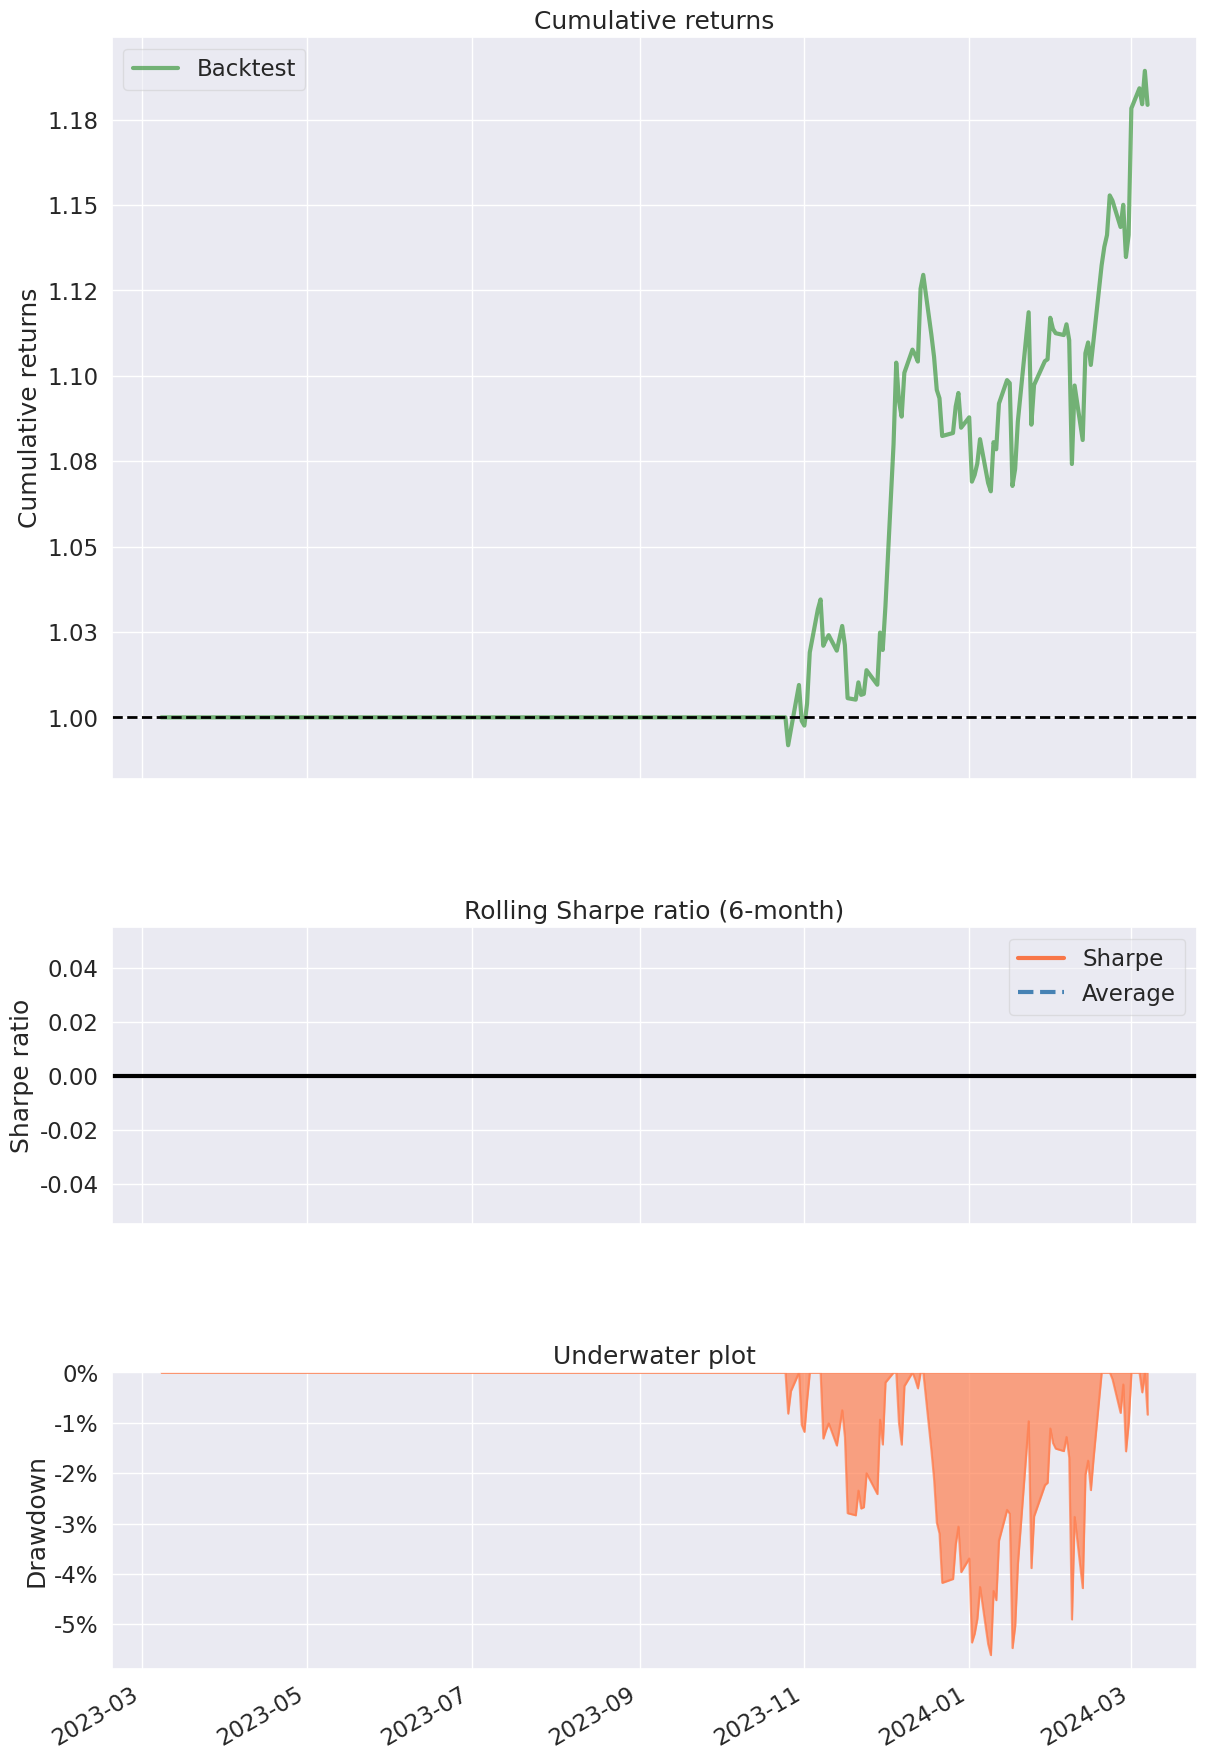

In [195]:
# Setting up the calculations for RSI 

df_rsi = ticker_df.copy(deep=True)
rsi_window = 14

rsi_upper_limit = 80
rsi_lower_limit = 29

df_rsi['RSI'] = ta.momentum.RSIIndicator( df_rsi['Close'], window = rsi_window ).rsi()

#generate signal
df_rsi['rsi_signal'] = 1 #initialize with default value

# BUY condition
df_rsi['rsi_signal'] = np.where((df_rsi['RSI'] > rsi_upper_limit),0,np.nan)

# SELL condition
df_rsi['rsi_signal'] = np.where( (df_rsi['RSI'] < rsi_lower_limit ),1,df_rsi['rsi_signal'])

df_rsi['rsi_signal_shift' ] = df_rsi['rsi_signal'].shift(1)

# update the signal keep the buy or sell signal is in the middle of upper & lower limit

df_rsi['rsi_signal'] = np.where ( ( df_rsi['RSI'] < rsi_upper_limit ) & ( df_rsi['RSI'] > rsi_lower_limit ), df_rsi['rsi_signal_shift'], df_rsi['rsi_signal'] )

#generate positions
# creating long and short positions
df_rsi['rsi_position'] = df_rsi['rsi_signal'].replace(to_replace=np.nan, method='ffill')

#calculate returns
df_rsi['daily_returns'] = np.log(df_rsi['Close'] / df_rsi['Close'].shift(1))

df_rsi['returns'] = df_rsi['daily_returns'] * (df_rsi['rsi_position'])

# add the descriptive statistics to the list
descriptive_stats['rsi'] = df_rsi['returns'].describe()

# add the custom metrics to the dataframe for comparison
tmp = get_performance_metrics( df_rsi['returns'].dropna( ))
custom_metrics['rsi'] = pd.Series( tmp.values(), index=tmp.keys())

# add the pyfolio to the dataframe for comparison
pf.create_simple_tear_sheet( df_rsi['returns'] )
pyfolio_metrics['rsi'] = pf.timeseries.perf_stats(  df_rsi['returns'].dropna( ) )




Start date,2023-03-08
End date,2024-03-07
Total months,11
,Backtest
Annual return,17.2%
Cumulative returns,16.9%
Annual volatility,14.2%
Sharpe ratio,1.29
Calmar ratio,2.30
Stability,0.24
Max drawdown,-7.5%


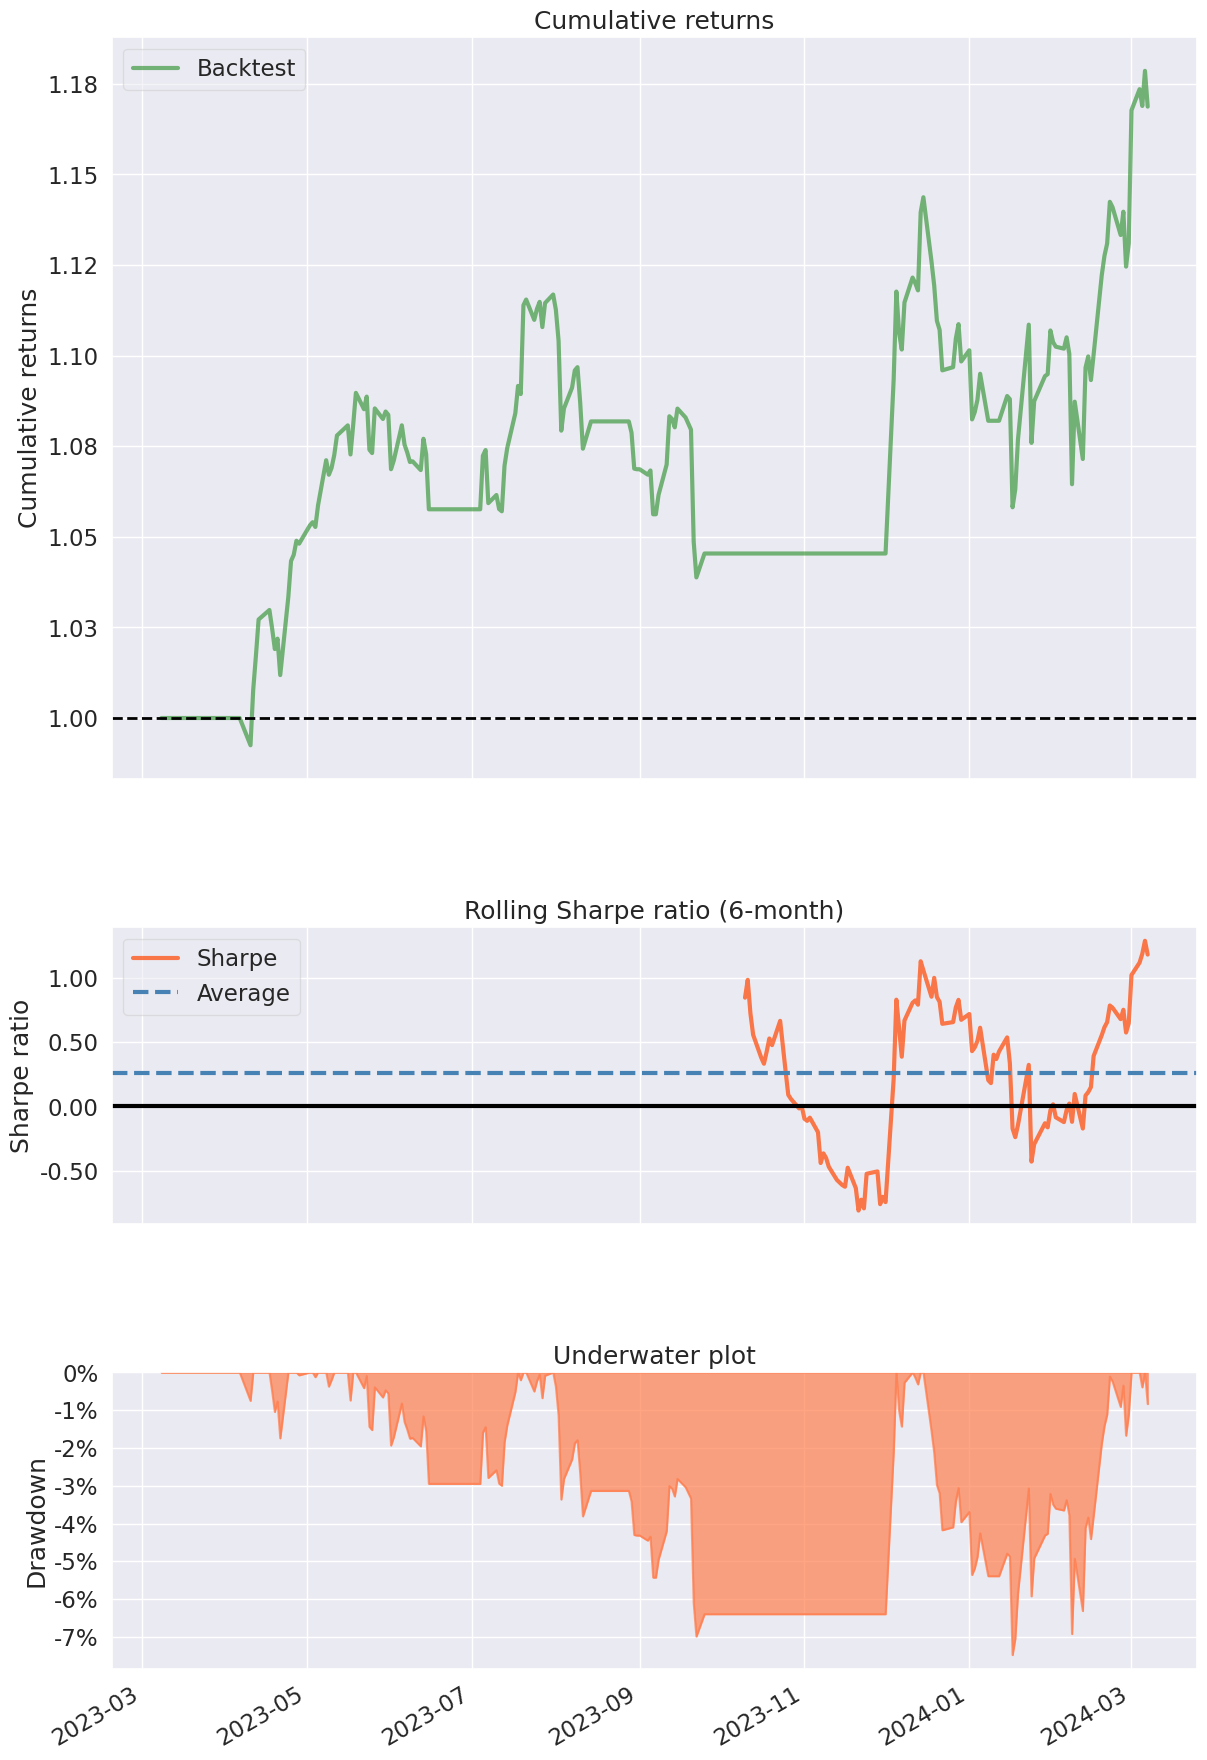

In [196]:
# Setting up the calculations for Exponential Moving Average - Cross Over

df_ema = ticker_df.copy( deep=True )
long_window  = 20
short_window = 10

df_ema[ 'short'] = ta.trend.EMAIndicator( df_sma['Close'], window=short_window).ema_indicator()
df_ema[ 'long' ] = ta.trend.EMAIndicator( df_sma['Close'], window=long_window ).ema_indicator()

# EMA Cross over Strategy 

# Position Strategy
# BUY condition
df_ema['ema_signal'] = np.where((df_ema['short'] > df_ema['long']),1,np.nan)
# SELL condition
df_ema['ema_signal'] = np.where( (df_ema['short'] < df_ema['long']),0,df_ema['ema_signal'])

# creating long and short positions
df_ema['ema_position'] = df_ema['ema_signal'].replace(to_replace=np.nan, method='ffill')

# shifting by 1, to account of close price return calculations
df_ema['ema_position'] = df_ema['ema_position'].shift(1)

# calculating returns
df_ema['returns'] = df_ema['daily_returns'] * (df_ema['ema_position'])

# add the descriptive statistics to the list
descriptive_stats['ema'] = df_ema['returns'].describe()

# add the custom metrics to the dataframe for comparison
tmp = get_performance_metrics( df_ema['returns'].dropna( ))
custom_metrics['ema'] = pd.Series( tmp.values(), index=tmp.keys())

# add the pyfolio to the dataframe for comparison
pf.create_simple_tear_sheet( df_ema['returns'] )
pyfolio_metrics['ema'] = pf.timeseries.perf_stats(  df_ema['returns'].dropna( ) )


Start date,2023-03-08
End date,2024-03-07
Total months,11
,Backtest
Annual return,16.5%
Cumulative returns,16.2%
Annual volatility,13.5%
Sharpe ratio,1.25
Calmar ratio,2.79
Stability,0.64
Max drawdown,-5.9%


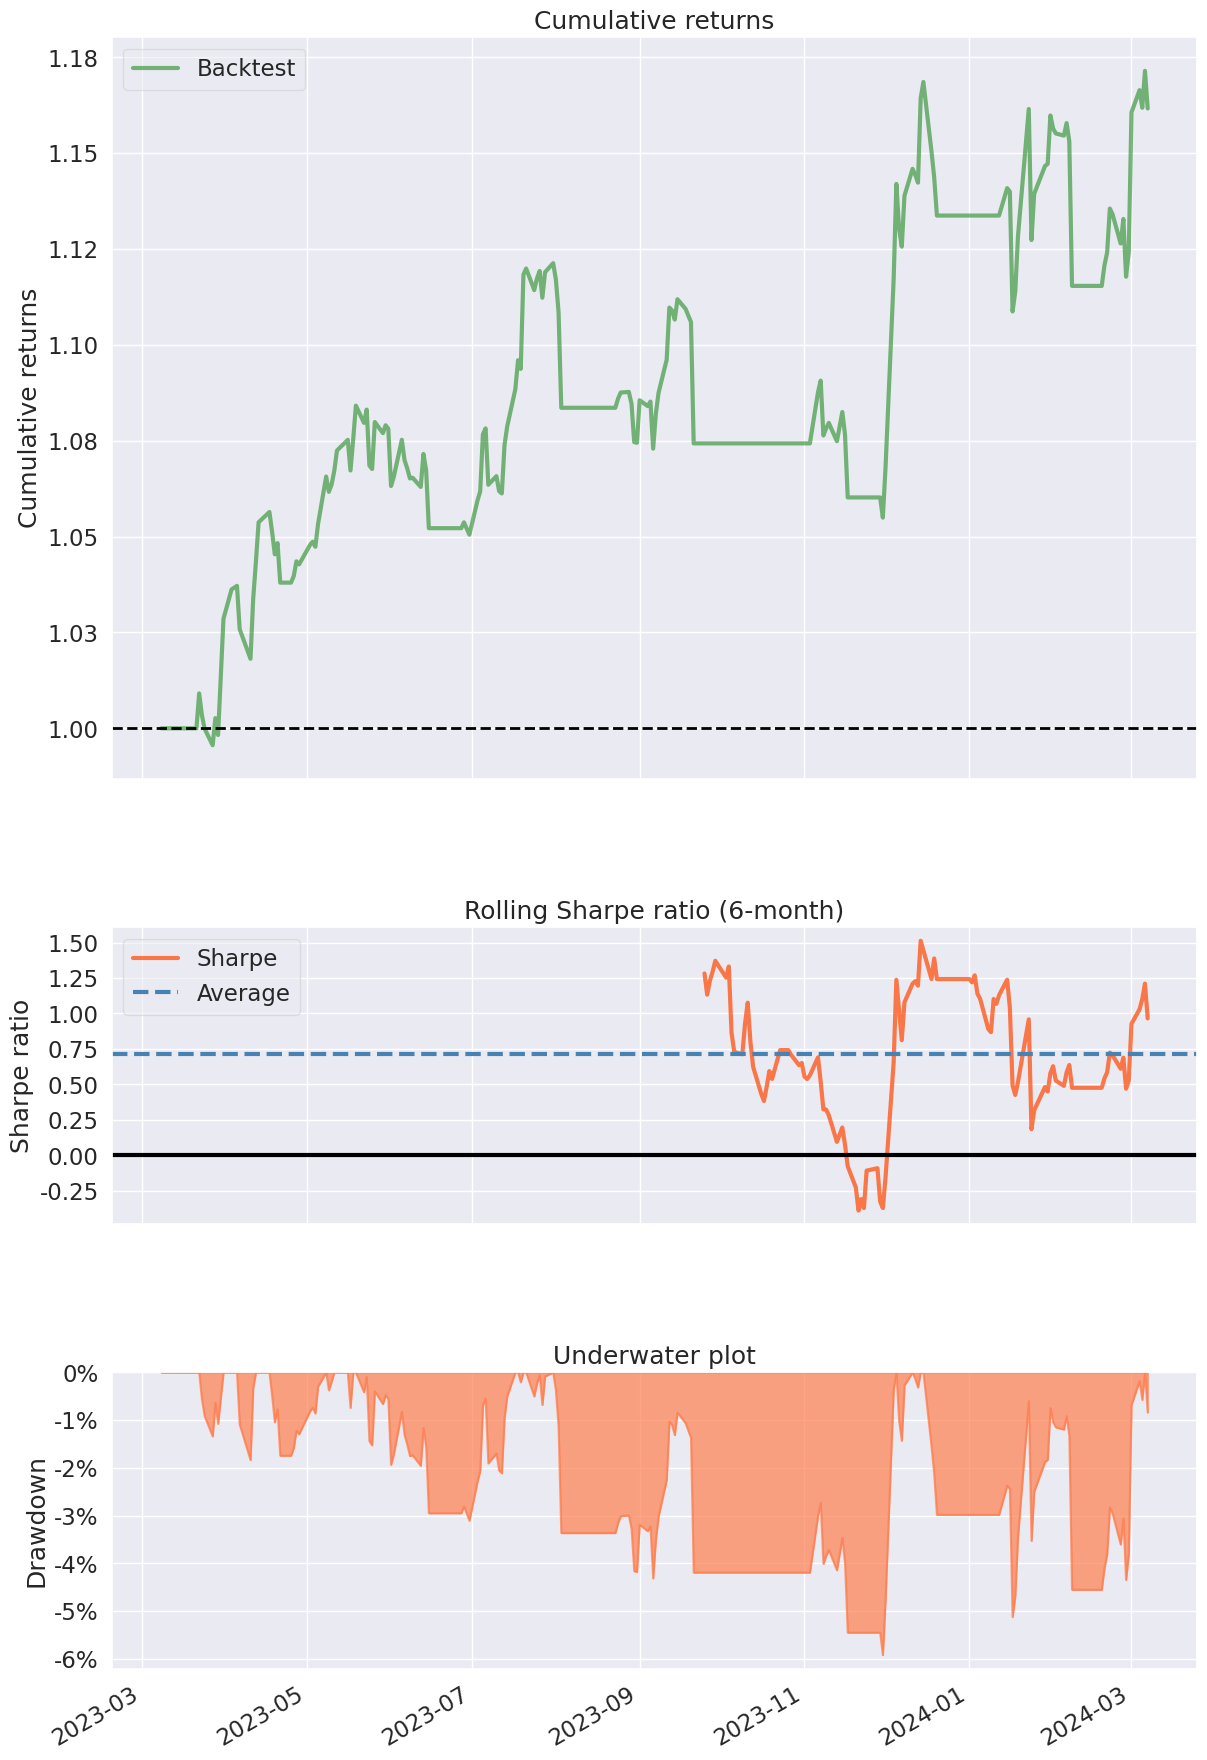

In [197]:
# Setting up Donchain Channel 

df_dcc = ticker_df.copy( deep=True )
#df_dcc.drop( 'daily_returns', inplace=True)

# Define the Donchian Channel window size
channel_window = 5

# Calculate the Donchian Channels
high = df_dcc['High'].rolling(window=channel_window).max()
low = df_dcc['Low'].rolling(window=channel_window).min()

upper_channel = high.shift(1)
lower_channel = low.shift(1)

# Generate trading signals
df_dcc['Signal'] = np.where(df_dcc['Close'] > upper_channel, 1, np.nan)
df_dcc['Signal']= np.where(df_dcc['Close'] < lower_channel, 0, df_dcc['Signal'])
df_dcc['position'] = df_dcc['Signal'].replace(to_replace=np.nan, method='ffill')

# Calculate daily returns
df_dcc['daily_returns'] = np.log(df_dcc['Close'] / df_dcc['Close'].shift(1))
df_dcc['returns'] = np.log(df_dcc['Close'] / df_dcc['Close'].shift(1)) * df_dcc['position'].shift(1)

# add the descriptive statistics to the list
descriptive_stats['dcc'] = df_dcc['returns'].describe()

# add the custom metrics to the dataframe for comparison
tmp = get_performance_metrics( df_dcc['returns'].dropna( ))
custom_metrics['dcc'] = pd.Series( tmp.values(), index=tmp.keys())

# add the pyfolio to the dataframe for comparison
pf.create_simple_tear_sheet( df_dcc['returns'] )
pyfolio_metrics['dcc'] = pf.timeseries.perf_stats(  df_dcc['returns'].dropna( ) )

Start date,2023-03-08
End date,2024-03-07
Total months,11
,Backtest
Annual return,16.5%
Cumulative returns,16.2%
Annual volatility,13.5%
Sharpe ratio,1.25
Calmar ratio,2.79
Stability,0.64
Max drawdown,-5.9%


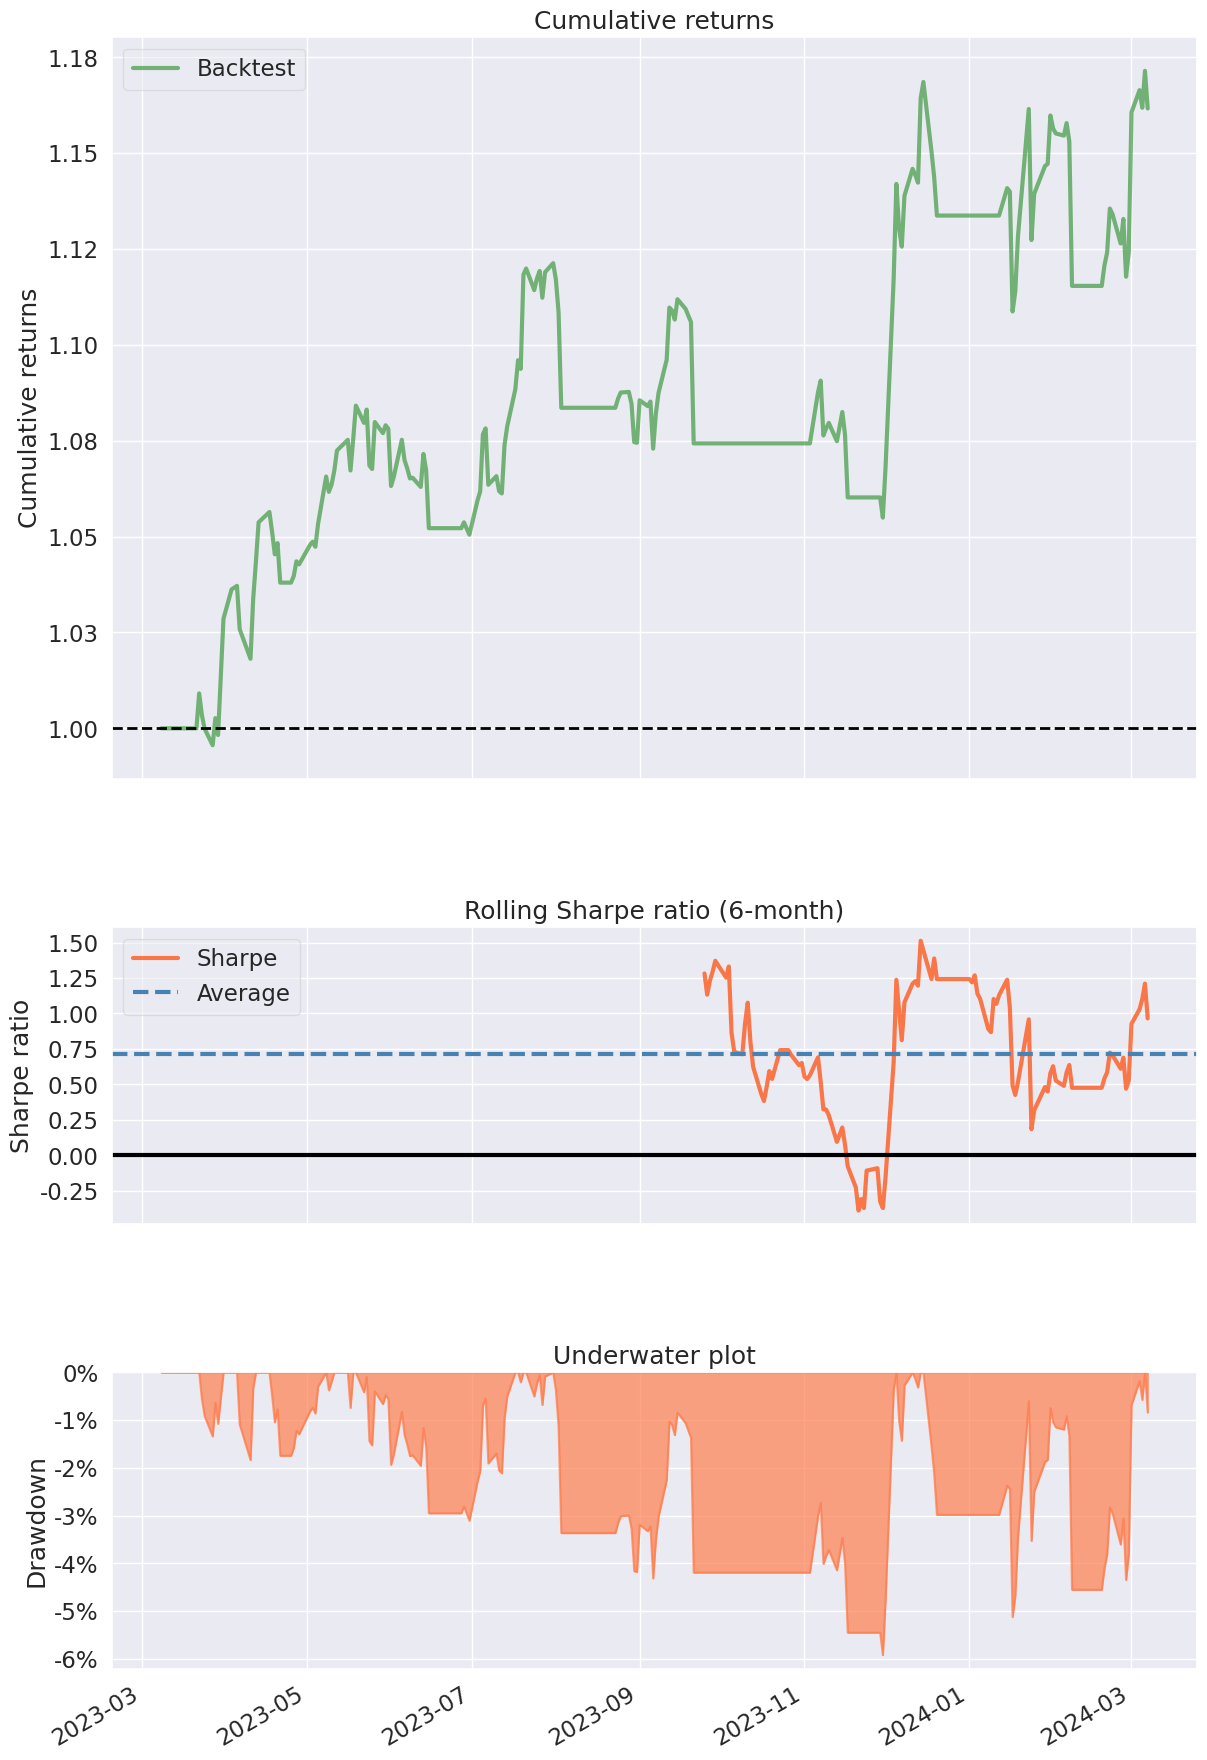

In [198]:
#Bollinger Band Calculation

df_bb = ticker_df.copy( deep=True )

# Define the Bollinger Band Parameters
n = 10 # period for moving averages
multiplier_L = 1
multiplier_R = 1.25

# Calculate the Bollinger Bands
bollinger_mean = df_bb['Close'].rolling(window=n).mean()
bollinger_sd = df_bb['Close'].rolling(window=n).std()

df_bb['bb_high'] = bollinger_mean + multiplier_R * bollinger_sd
df_bb['bb_low' ] = bollinger_mean - multiplier_L * bollinger_sd

# Generate trading signals breakout str
df_bb['Signal'] = np.where(df_bb['Close'] >df_bb['bb_high'], 1, np.nan)
df_bb['Signal']= np.where(df_bb['Close'] < df_bb['bb_low'], 0, df_bb['Signal'])
df_bb['position'] = df_bb['Signal'].replace(to_replace=np.nan, method='ffill')

df_bb['returns'] = np.log(df_bb['Close'] / df_bb['Close'].shift(1)) * df_bb['position'].shift(1)

# add the descriptive statistics to the list
descriptive_stats['bb'] = df_bb['returns'].describe()

# add the custom metrics to the dataframe for comparison
tmp = get_performance_metrics( df_bb['returns'].dropna( ))
custom_metrics['bb'] = pd.Series( tmp.values(), index=tmp.keys())

# add the pyfolio to the dataframe for comparison
pf.create_simple_tear_sheet( df_dcc['returns'] )
pyfolio_metrics['bb'] = pf.timeseries.perf_stats(  df_bb['returns'].dropna( ) )



In [199]:
print( "Descriptive Stats" )
descriptive_stats.head(20)

Descriptive Stats


,sma,rsi,ema,dcc,bb
count,227.000000,91.000000,227.000000,237.000000,236.000000
mean,0.000328,0.001889,0.000727,0.000668,0.000532
std,0.007675,0.012335,0.008932,0.008486,0.008053
min,-0.032666,-0.032666,-0.032666,-0.032666,-0.032666
25%,-0.001283,-0.004338,-0.001386,-0.001318,-0.000770
50%,0.000000,0.001831,0.000000,0.000000,0.000000
75%,0.002802,0.007001,0.003628,0.002799,0.001813
max,0.032446,0.045934,0.045934,0.045934,0.045934


In [200]:
print( "Custom Metrics")
custom_metrics.head( 20 )

Custom Metrics


,sma,rsi,ema,dcc,bb
annual_return,0.082672,0.476100,0.183131,0.168424,0.134129
annual_volatility,0.121573,0.194734,0.141482,0.134433,0.127563
sharpe_ratio,0.127361,2.099843,0.819490,0.753056,0.524767
max_drawdown,-2.451881,-2.019410,-2.271973,-1.942013,-1.942013
calmar_ratio,0.006315,0.202491,0.051032,0.052129,0.034470
daily_value_at_risk,0.012925,0.022067,0.015387,0.014598,0.013750
sortino_ratio,0.141954,3.326943,0.999770,0.887177,0.596863
omega_ratio,1.157282,1.525558,1.320300,1.324124,1.283156
tail_ratio,0.918365,1.418934,1.019165,0.943719,1.118062


In [201]:
print ( "PyFolio Metrics")
pyfolio_metrics.head(20)

PyFolio Metrics


,sma,rsi,ema,dcc,bb
Annual return,0.078167,0.579008,0.188974,0.172765,0.134269
Cumulative returns,0.070147,0.179339,0.168732,0.161693,0.125232
Annual volatility,0.121842,0.195813,0.141795,0.134718,0.127834
Sharpe ratio,0.678517,2.431396,1.291522,1.250198,1.049242
Calmar ratio,0.604771,10.320276,2.525983,2.918904,1.476247
Stability,0.231848,0.753150,0.237742,0.635649,0.211582
Max drawdown,-0.129251,-0.056104,-0.074812,-0.059188,-0.090953
Omega ratio,1.157282,1.525558,1.320300,1.324124,1.283156
Sortino ratio,0.972531,4.016771,2.003420,1.948220,1.639311
Skew,-0.226266,0.274647,0.393457,0.476805,0.585029
